In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
# Read data from csv
df = pd.read_csv("data/rental_prices_singapore_preprocessed.csv")

In [3]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               1680 non-null   int64  
 1   size                1680 non-null   int64  
 2   bedrooms            1680 non-null   object 
 3   bathrooms           1680 non-null   int64  
 4   latitude            1680 non-null   float64
 5   longitude           1680 non-null   float64
 6   meters_to_cbd       1680 non-null   int64  
 7   meters_to_school    1680 non-null   int64  
 8   restaurants_rating  1680 non-null   float64
 9   property_type       1680 non-null   object 
 10  furnishing          1680 non-null   object 
 11  year                1680 non-null   int64  
 12  meters_to_mrt       1680 non-null   int64  
 13  high_floor          1680 non-null   bool   
 14  new                 1680 non-null   bool   
 15  renovated           1680 non-null   bool   
 16  view  

In [4]:
# Show top five rows
df.head()

,price,size,bedrooms,bathrooms,latitude,longitude,meters_to_cbd,meters_to_school,restaurants_rating,property_type,furnishing,year,meters_to_mrt,high_floor,new,renovated,view,penthouse
0,3000,400,1,1,1.312952,103.887868,6744,422,4.126316,Apartment,Fully Furnished,2013,450,False,False,False,False,False
1,2000,1130,Room,1,1.328820,103.912904,14317,3422,3.800000,Apartment,Fully Furnished,2013,810,False,False,False,False,False
2,7400,3800,5,4,1.389444,103.857002,15497,568,4.710000,Apartment,Fully Furnished,2013,450,False,False,False,False,False
3,1000,120,Room,1,1.429261,103.828917,22825,1090,3.605263,Apartment,Fully Furnished,2013,700,False,False,False,False,False
4,4300,689,1,1,1.297356,103.836707,3070,1262,4.120000,Apartment,Fully Furnished,2013,420,False,False,False,False,False


# Handle rare categories

In [5]:
# Show category frequencies of bedrooms
df["bedrooms"].value_counts()

3         479
2         438
1         245
4         207
Room      135
5          89
6          39
Studio     27
7          14
8           5
9           1
10          1
Name: bedrooms, dtype: int64

In [6]:
# Combine 7, 8, 9 and 10 bedrooms into one category
df["bedrooms"]= df["bedrooms"].replace({"8": "7", "9": "7", "10": "7"})

# Rename this category to "7+"
df["bedrooms"]= df["bedrooms"].replace({"7": "7+"})

In [7]:
# Show category frequencies of bedrooms
df["bedrooms"].value_counts()

3         479
2         438
1         245
4         207
Room      135
5          89
6          39
Studio     27
7+         21
Name: bedrooms, dtype: int64

# Train-validation-test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Split the data into X features and y target
X = df.drop("price", axis=1)
y = df["price"]

In [10]:
# Split the data into training and temporary sets (70% train, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary data into validation and test sets (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Note: This accomplishes a 70% training, 15% validation and 15% test set size.

# Handle outliers

Note: Univariate outliers regarding rental price

## 3 SD

Criterion for outliers: 3 standard deviations (SD) above or below the mean 

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin


# Create a custom transformer class to handle outliers based on 3 SD
class OutlierHandler3SD(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate mean, standard deviation, and cutoff values of target label (y)
        self.mean_ = y.mean()
        self.sd_ = y.std()
        self.lower_cutoff_ = self.mean_ - 3 * self.sd_
        self.upper_cutoff_ = self.mean_ + 3 * self.sd_
        print(f"Lower cutoff: {round(self.lower_cutoff_)} S$/month")
        print(f"Upper cutoff: {round(self.upper_cutoff_)} S$/month")
        return self

    def transform(self, X, y):
        # Apply cutoff values
        mask = (y >= self.lower_cutoff_) & (y <= self.upper_cutoff_)
        # Print number of outliers
        print(f"Rental price outliers based on 3 SD: {y.shape[0] - y[mask].shape[0]}")
        # Return data with outliers removed 
        return X[mask], y[mask]

    def fit_transform(self, X, y):
        # Perform both fit and transform 
        return self.fit(X, y).transform(X, y)

In [12]:
# Initialize an OutlierHandler3SD object
outlier_handler_3sd = OutlierHandler3SD()

In [13]:
# Remove outliers in training, validation and test data
X_train_no_outliers, y_train_no_outliers = outlier_handler_3sd.fit_transform(X_train, y_train)
X_val_no_outliers, y_val_no_outliers = outlier_handler_3sd.transform(X_val, y_val)
X_test_no_outliers, y_test_no_outliers = outlier_handler_3sd.transform(X_test, y_test)

Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
Rental price outliers based on 3 SD: 2


## 1.5 IQR

Criterion for outliers: 1.5 interquartile ranges (IQR) above the 3. quartile or below the 1. quartile 

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin


# Create a custom transformer class to handle outliers based on 1.5 IQR
class OutlierHandlerIQR(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate quartiles, IQR and cutoff values of target label (y) 
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        self.lower_cutoff_ = Q1 - 1.5 * IQR
        self.upper_cutoff_ = Q3 + 1.5 * IQR
        print(f"Lower cutoff: {round(self.lower_cutoff_)} S$/month")
        print(f"Upper cutoff: {round(self.upper_cutoff_)} S$/month")
        return self

    def transform(self, X, y):
        # Apply cutoff values 
        mask = (y >= self.lower_cutoff_) & (y <= self.upper_cutoff_)
        # Print number of outliers
        print(f"Rental price outliers based on 1.5 IQR: {y.shape[0] - y[mask].shape[0]}")
        # Return data with outliers removed 
        return X[mask], y[mask]

    def fit_transform(self, X, y):
        # Perform both fit and transform
        return self.fit(X, y).transform(X, y)

In [15]:
# Initialize an OutlierHandlerIQR object
outlier_handler_iqr = OutlierHandlerIQR()

In [16]:
# Remove outliers in training, validation and test data
X_train_no_outliers, y_train_no_outliers = outlier_handler_iqr.fit_transform(X_train, y_train)
X_val_no_outliers, y_val_no_outliers = outlier_handler_iqr.transform(X_val, y_val)
X_test_no_outliers, y_test_no_outliers = outlier_handler_iqr.transform(X_test, y_test)

Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
Rental price outliers based on 1.5 IQR: 28


# Pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

LinearRegression()
OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 3896.71
MAPE: 0.28
R-squared (R²): 0.79


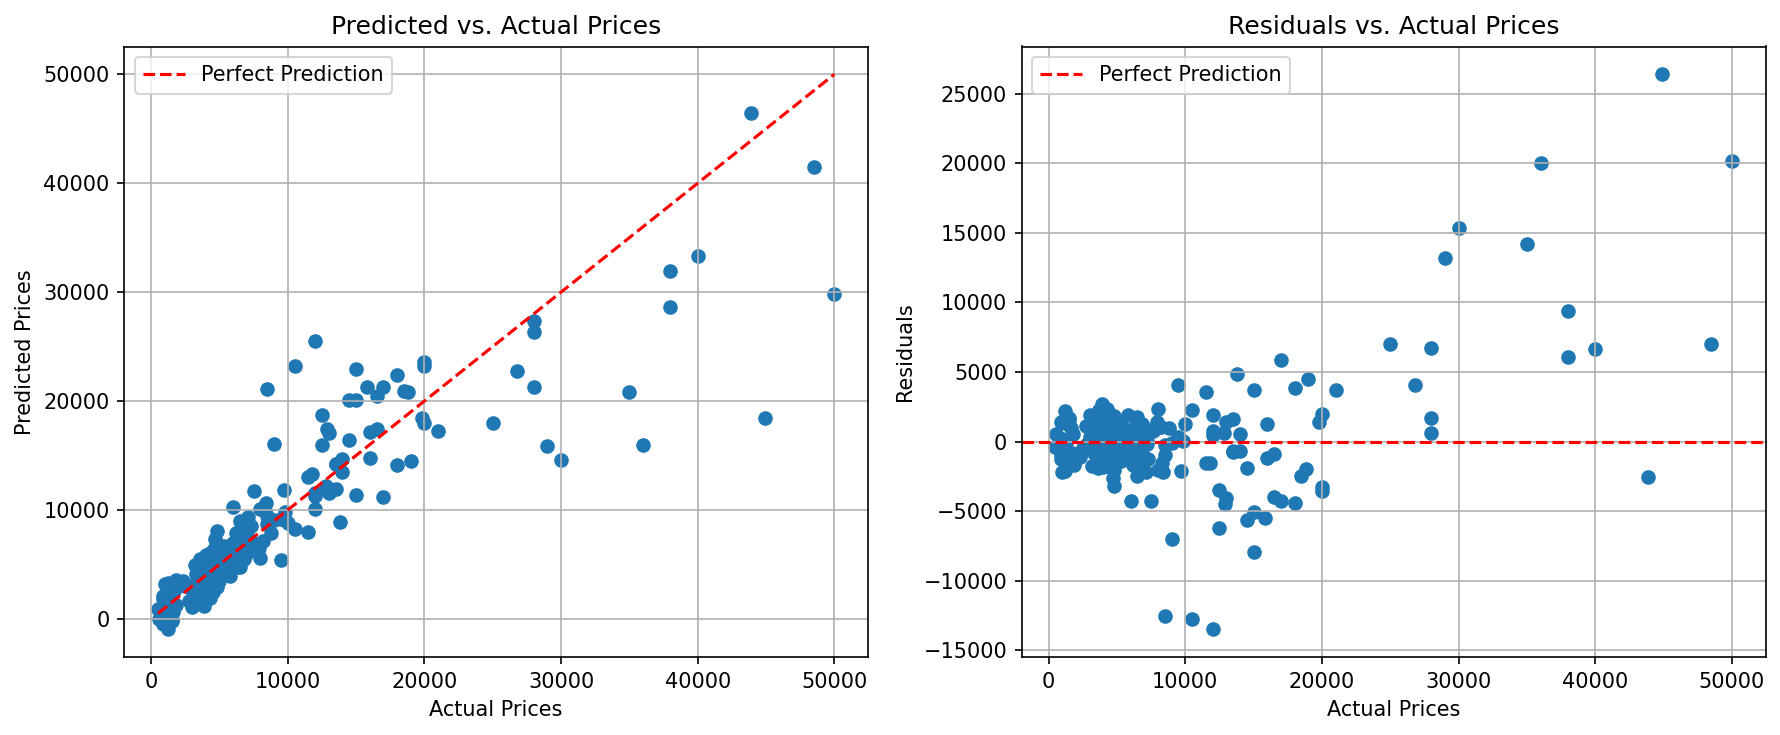

SVR()
OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 9222.27
MAPE: 0.67
R-squared (R²): -0.16


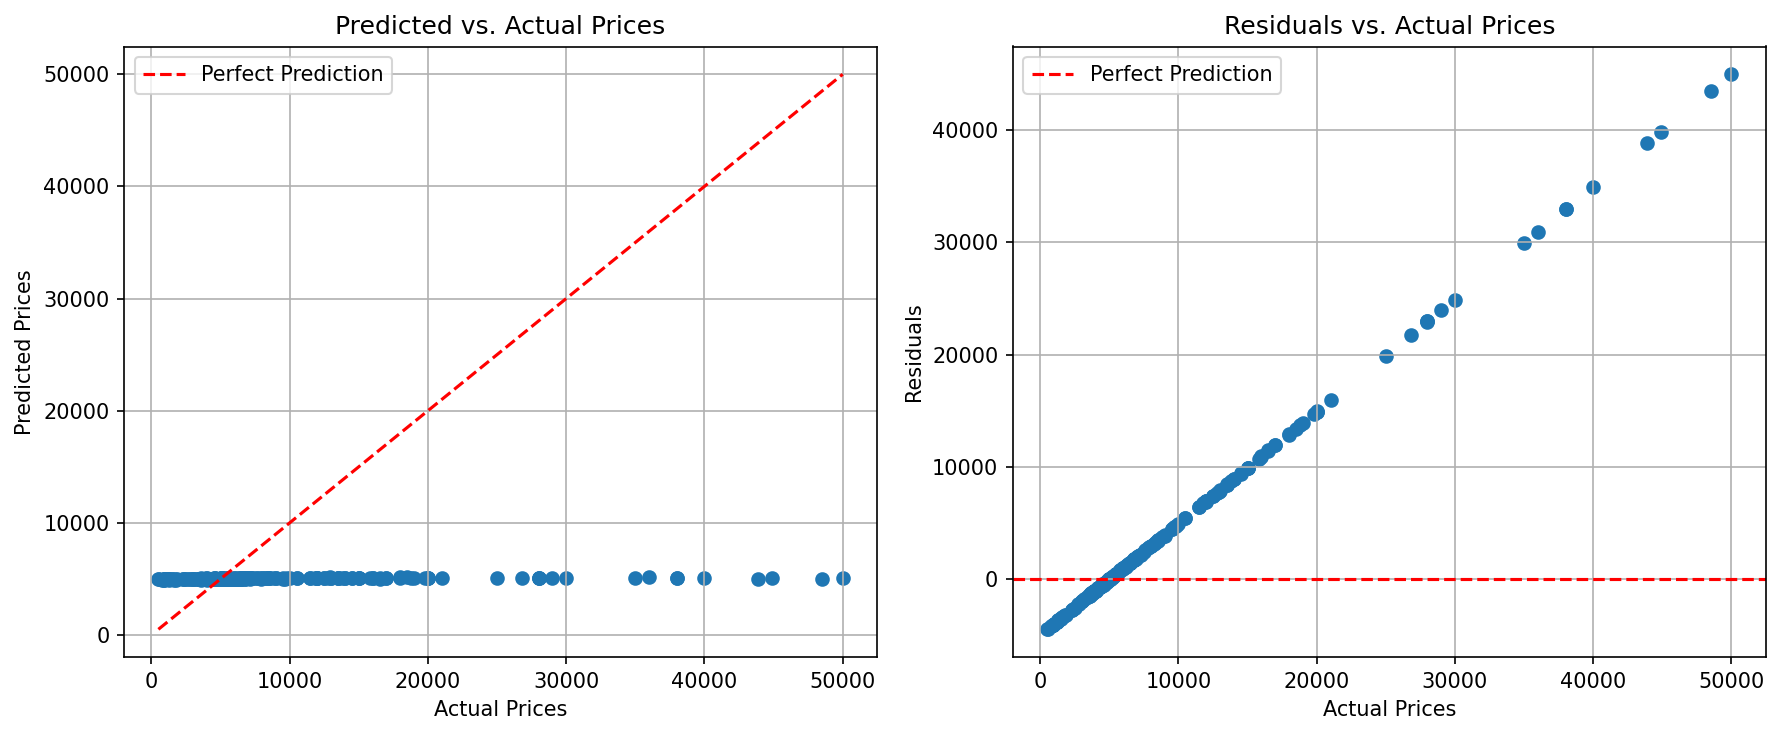

RandomForestRegressor()
OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 3745.06
MAPE: 0.18
R-squared (R²): 0.81


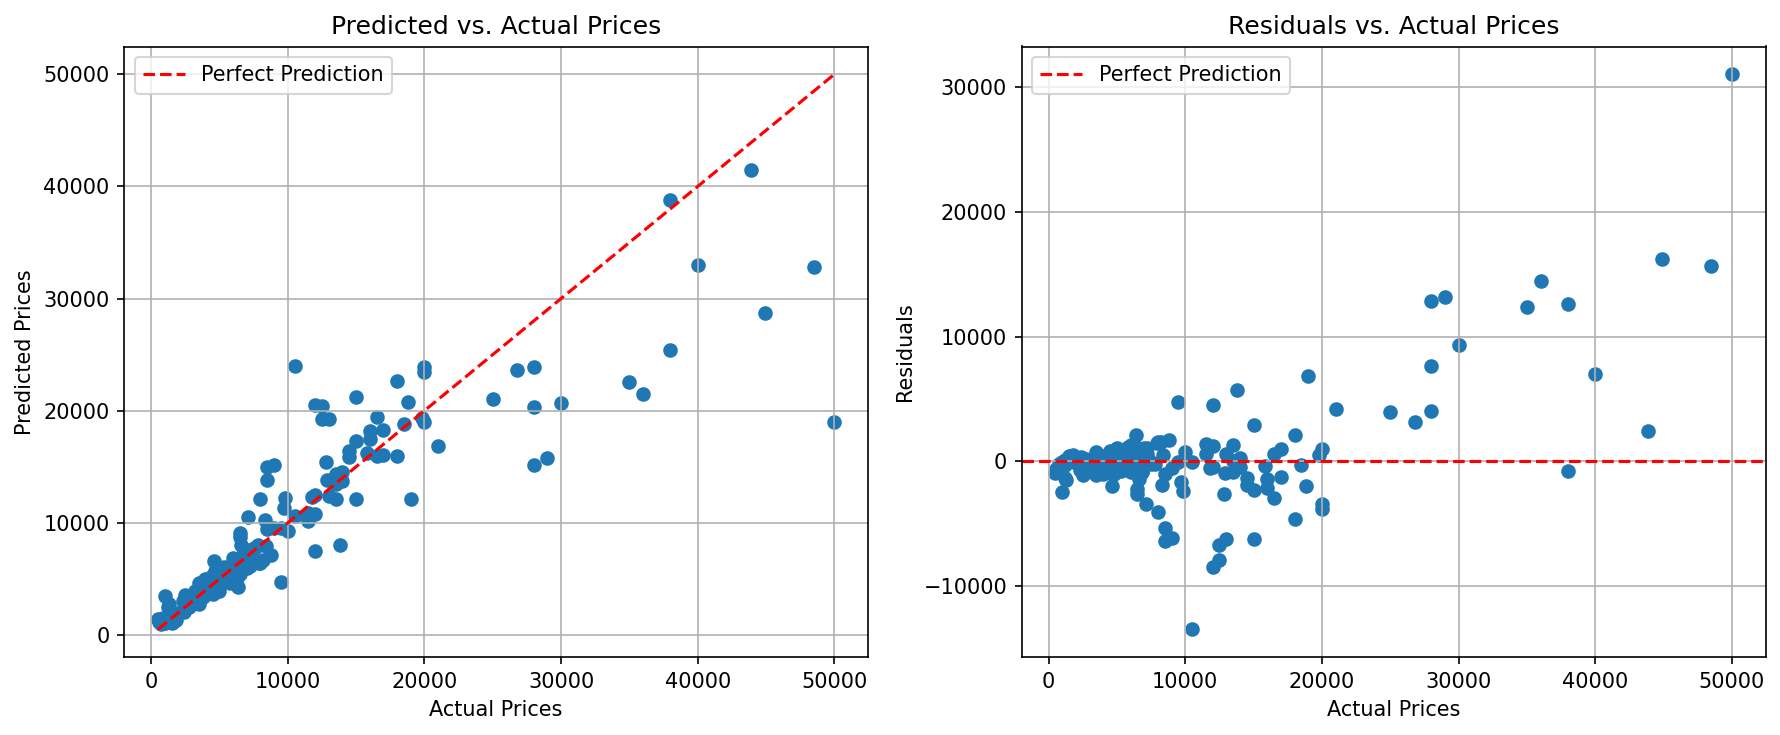

MLPRegressor()
OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2


C:\Users\Jens\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 10945.89
MAPE: 0.86
R-squared (R²): -0.63


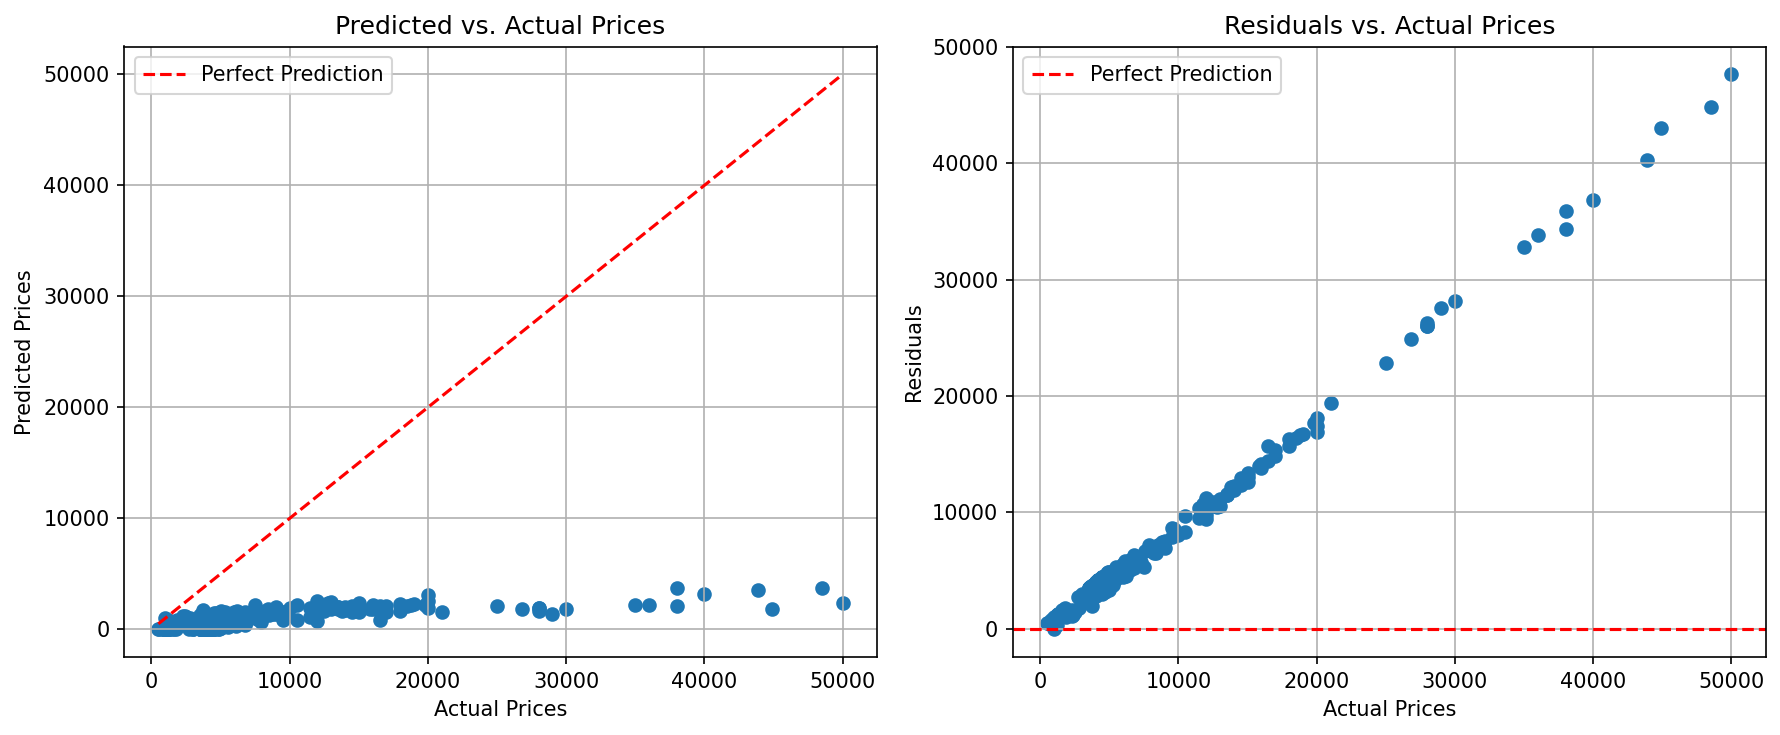

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
OutlierHandler3SD()
Lower cutoff: -37337 S$/month
Upper cutoff: 56094 S$/month
Rental price outliers based on 3 SD: 29
Rental price outliers based on 3 SD: 2
RMSE: 3655.52
MAPE: 0.19
R-squared (R²): 0.82


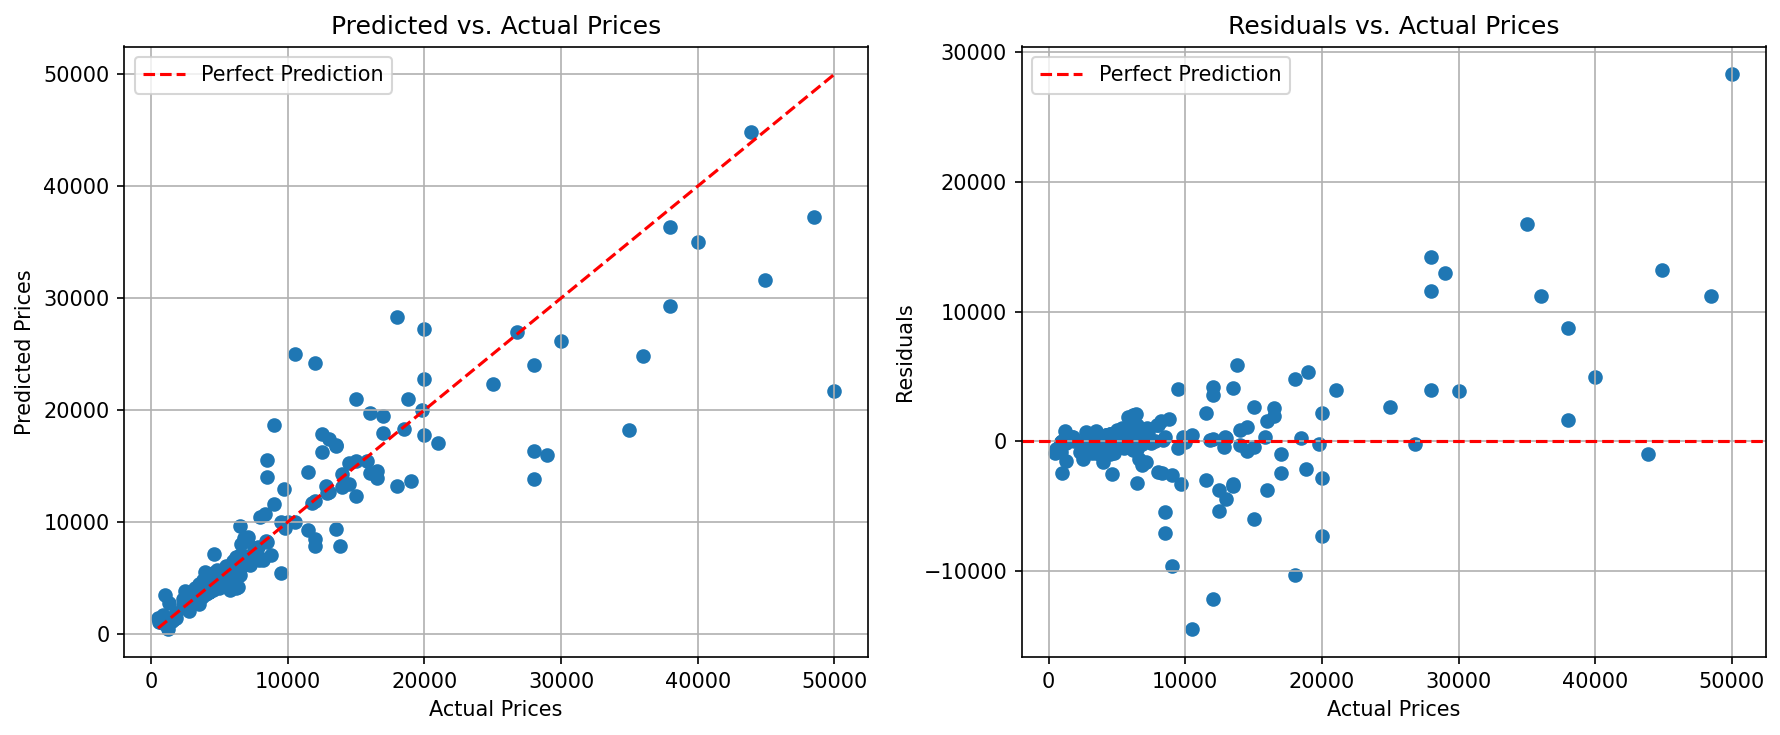

LinearRegression()
OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 1369.23
MAPE: 0.21
R-squared (R²): 0.83


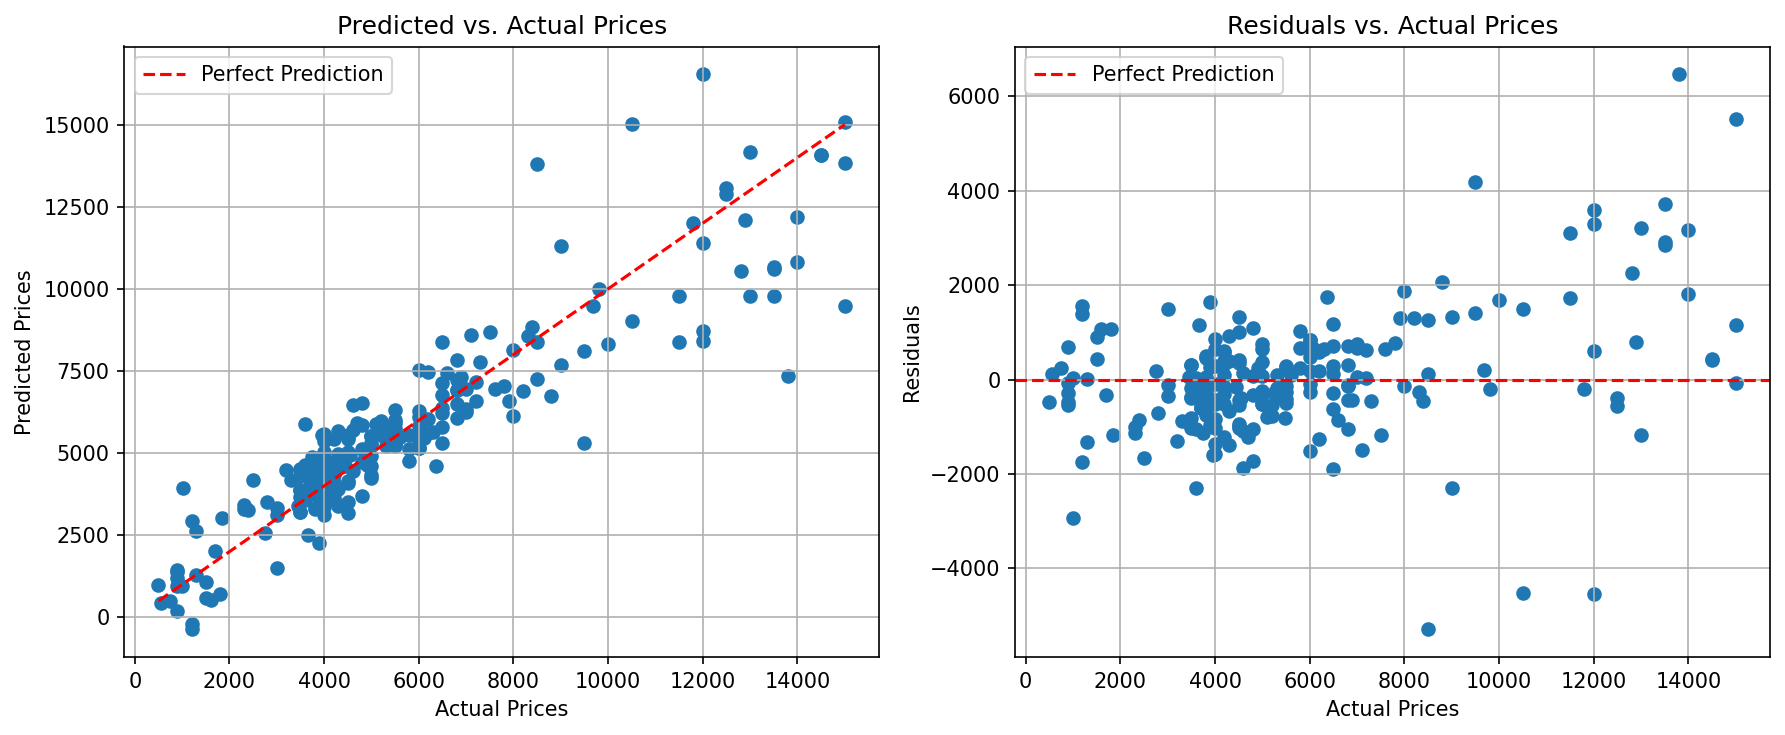

SVR()
OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 3432.62
MAPE: 0.61
R-squared (R²): -0.08


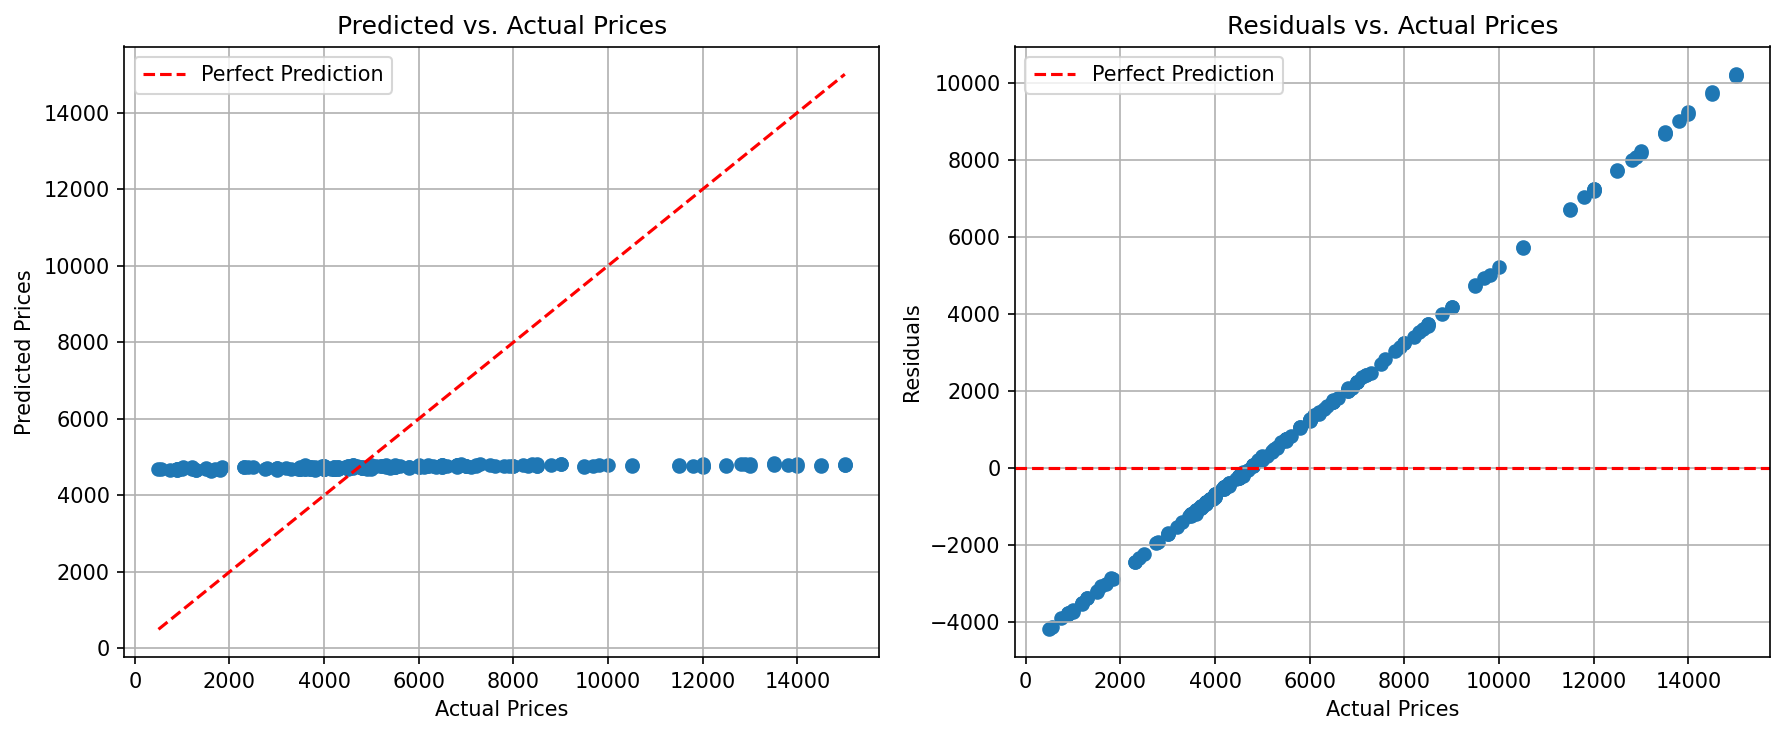

RandomForestRegressor()
OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 1095.04
MAPE: 0.15
R-squared (R²): 0.89


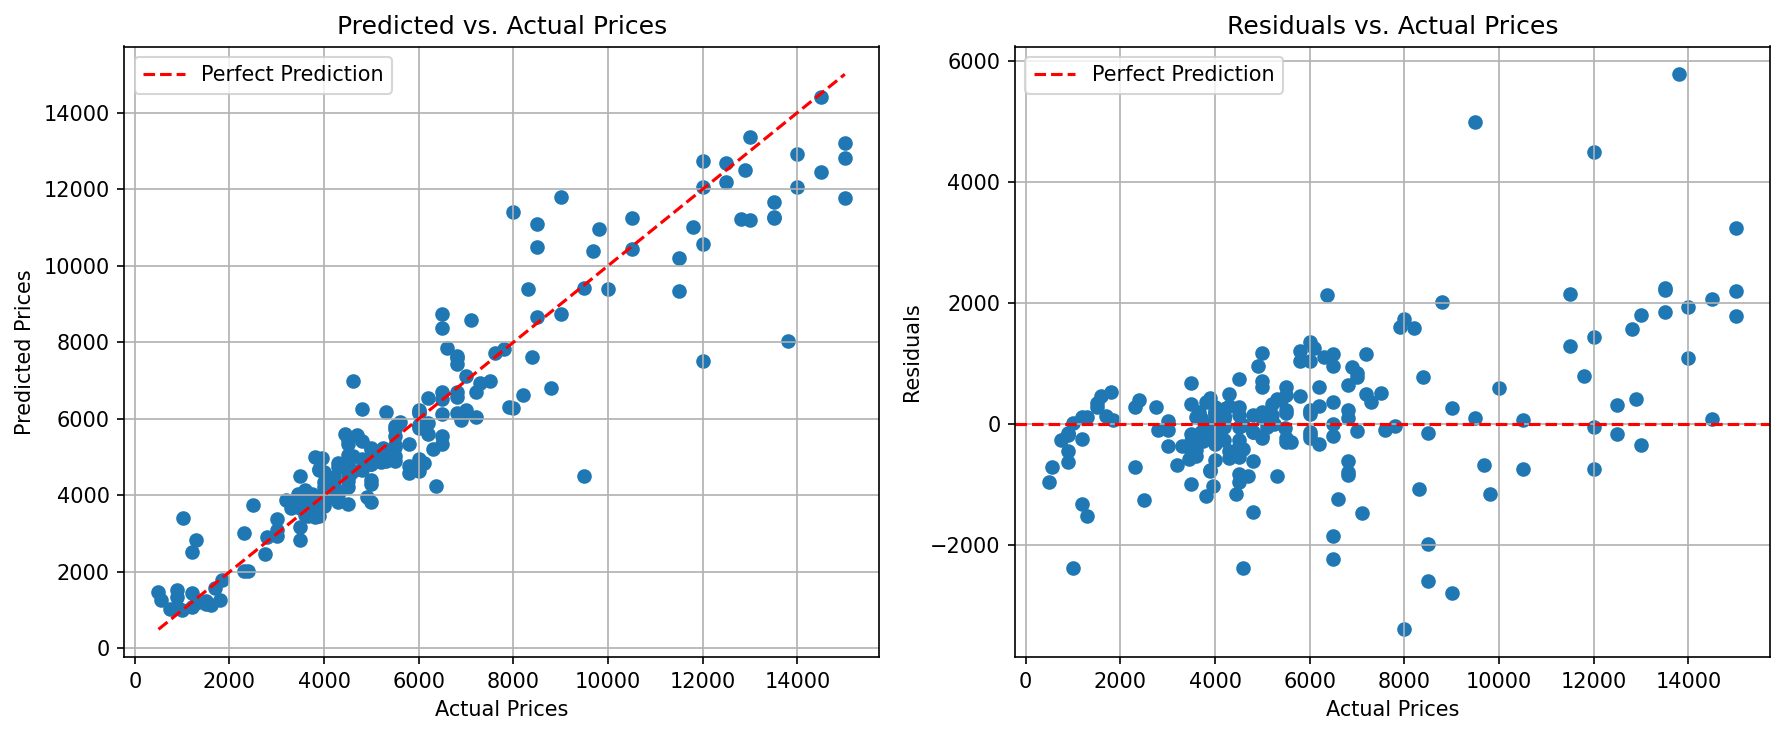

MLPRegressor()
OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35


C:\Users\Jens\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 5472.89
MAPE: 0.83
R-squared (R²): -1.74


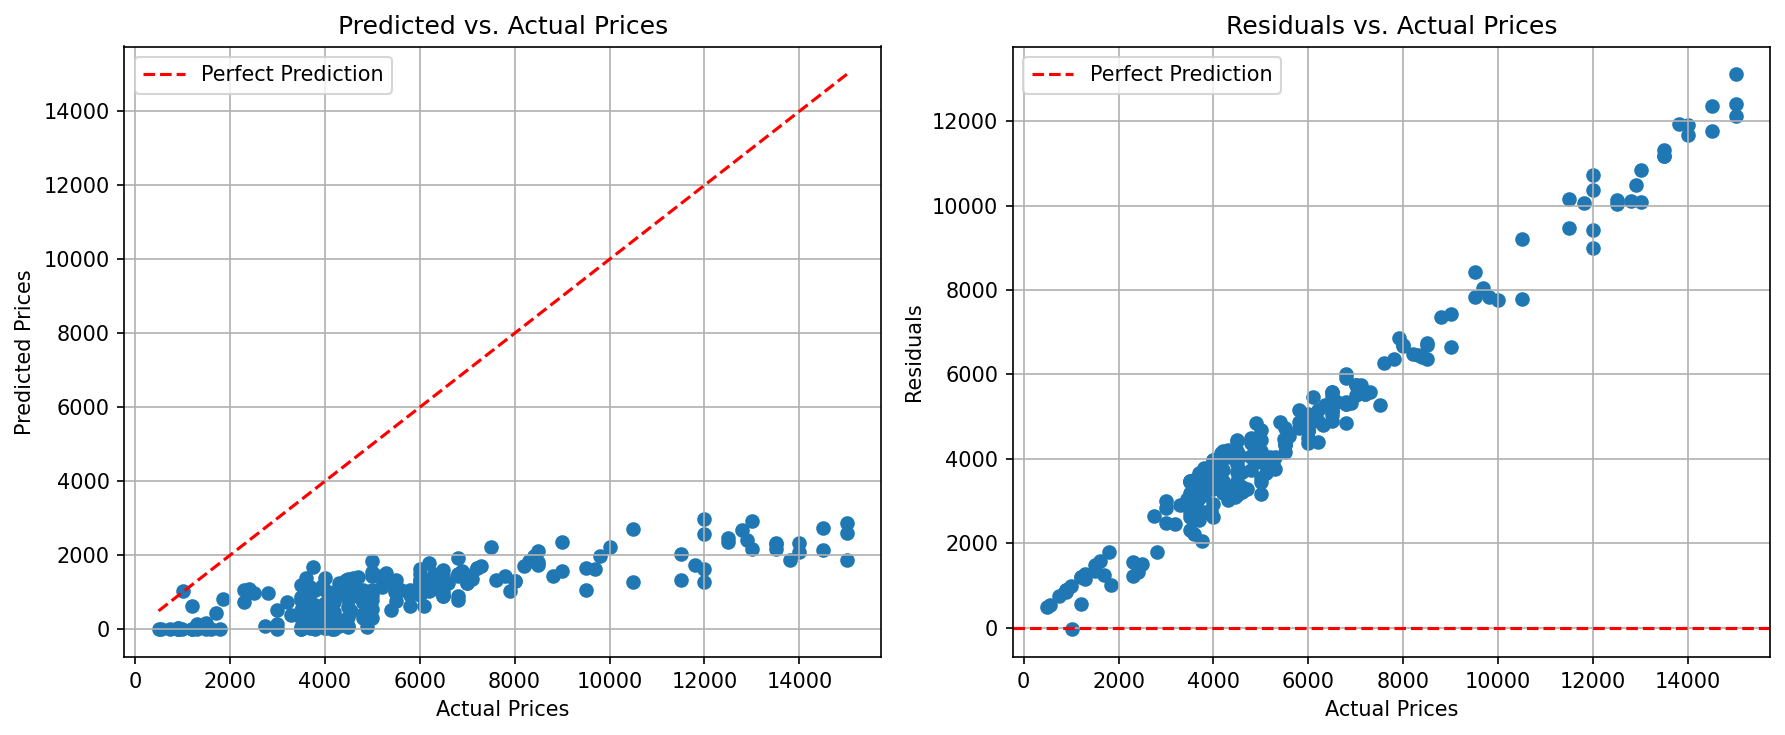

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
OutlierHandlerIQR()
Lower cutoff: -3000 S$/month
Upper cutoff: 15400 S$/month
Rental price outliers based on 1.5 IQR: 143
Rental price outliers based on 1.5 IQR: 35
RMSE: 1153.94
MAPE: 0.15
R-squared (R²): 0.88


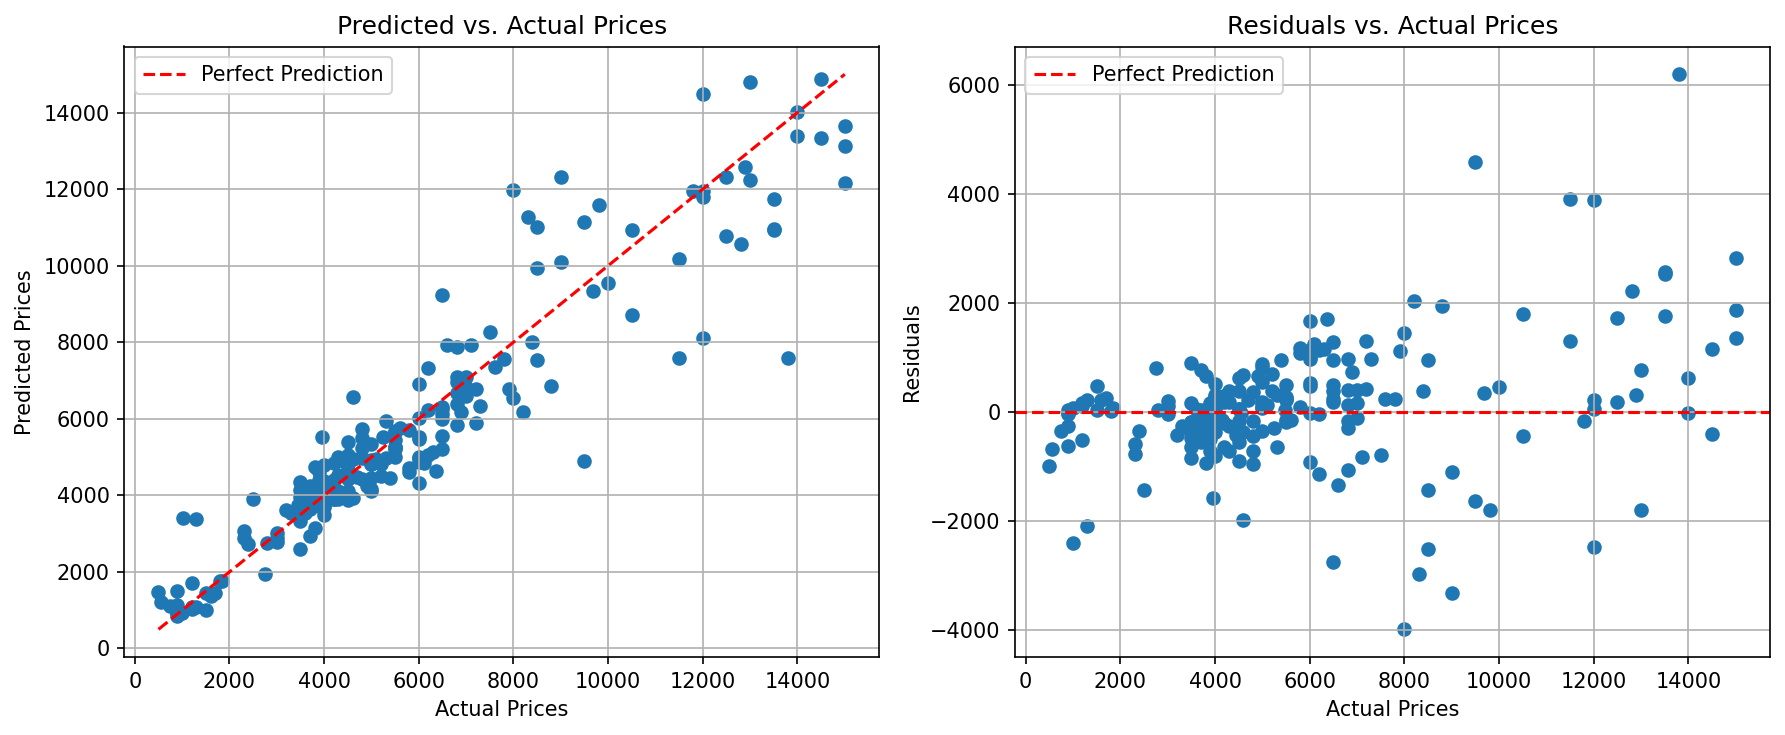

In [25]:
# Define outlier handlers
outlier_handlers = [OutlierHandler3SD(), OutlierHandlerIQR()]

# Define models
models = [LinearRegression(), SVR(), RandomForestRegressor(), MLPRegressor(), XGBRegressor()]

# Define numerical, categorical and boolean columns 
numerical_columns = ["size", "bathrooms", "latitude", "longitude", "meters_to_mrt", "meters_to_cbd", 
                     "meters_to_school", "restaurants_rating", "year"]
categorical_columns = ["bedrooms", "property_type", "furnishing"]
boolean_columns = ["high_floor", "new", "renovated", "view", "penthouse"]

# Create list for storing the predicted values of each model
y_val_pred_ls = []

# Create list for storing the 

# Create lists for storing the RMSE, MAPE and R2 of each model 
rmse_ls = []
mape_ls = []
r2_ls = []

# Loop through each outlier handler
for outlier_handler in outlier_handlers:
    # Loop through each model
    for model in models:
        # Print outlier handler and model
        print("=" * 100)
        print(model)
        print(outlier_handler)
        
        # Remove outliers
        X_train_no_outliers, y_train_no_outliers = outlier_handler.fit_transform(X_train, y_train)
        X_val_no_outliers, y_val_no_outliers = outlier_handler.transform(X_val, y_val)

        # Scale numerical columns and encode categorical columns 
        column_transformer = ColumnTransformer(
            transformers=[
                ("scaler", StandardScaler(), numerical_columns),
                ("encoder", OneHotEncoder(drop=None, sparse=False), categorical_columns)
            ],
            remainder="passthrough"  # Include the boolean columns without transformation
        )

        # Create a pipeline
        pipeline = Pipeline(steps=[
            ("column_transformer", column_transformer),
            ("model", model)
        ])

        # Fit the pipeline on the training data
        pipeline.fit(X_train_no_outliers, y_train_no_outliers)
        
        # Predict on the validation data
        y_val_pred = pipeline.predict(X_val_no_outliers)
        
        # Calculate evaluation metrics: RMSE, MAPE, R2
        rmse = mean_squared_error(y_val_no_outliers, y_val_pred, squared=False)
        mape = mean_absolute_percentage_error(y_val_no_outliers, y_val_pred)
        r2 = r2_score(y_val_no_outliers, y_val_pred)
        print(f"RMSE: {round(rmse, 2)}")
        print(f"MAPE: {round(mape, 2)}")
        print(f"R-squared (R²): {round(r2, 2)}")
        
        # Add the predicted values, RMSE, MAPE and R2 to their respective lists
        y_val_pred_ls.append(y_val_pred)
        rmse_ls.append(rmse)
        mape_ls.append(mape)
        r2_ls.append(r2)
        
        # Create residual plots
        # Calculate residuals
        residuals = [actual_value - predicted_value for actual_value, predicted_value in zip(y_val_no_outliers, y_val_pred)]

        # Create a 1x2 grid of subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

        # Plot 1: Predicted vs. Actual Prices
        axes[0].scatter(y_val_no_outliers, y_val_pred)
        axes[0].plot([min(y_val_no_outliers), max(y_val_no_outliers)], 
                     [min(y_val_no_outliers), max(y_val_no_outliers)], 
                     color="red", 
                     linestyle="--", 
                     label="Perfect Prediction")  # Add diagonal reference line
        axes[0].set_xlabel("Actual Prices")
        axes[0].set_ylabel("Predicted Prices")
        axes[0].set_title("Predicted vs. Actual Prices")
        axes[0].grid(True)
        axes[0].legend() 

        # Plot 2: Residuals vs. Actual Prices
        axes[1].scatter(y_val_no_outliers, residuals)
        axes[1].axhline(y=0, color="red", linestyle="--", label="Perfect Prediction")  # Add horizontal reference line
        axes[1].set_xlabel("Actual Prices")
        axes[1].set_ylabel("Residuals")
        axes[1].set_title("Residuals vs. Actual Prices")
        axes[1].grid(True)
        axes[1].legend() 

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.show()

In [22]:
# Comparison tables of model metrics
# Create table for handling outliers based on 3 SD 
comparison_table_3sd = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", "Neural Network", "XGBoost"],
    "RMSE": [rmse_ls[0], rmse_ls[1], rmse_ls[2], rmse_ls[3], rmse_ls[4]],
    "MAPE": [mape_ls[0], mape_ls[1], mape_ls[2], mape_ls[3], mape_ls[4]],
    "R-squared (R²)": [r2_ls[0], r2_ls[1], r2_ls[2], r2_ls[3], r2_ls[4]]
})

# Create table for handling outliers based on 1.5 IQR 
comparison_table_iqr = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", "Neural Network", "XGBoost"],
    "RMSE": [rmse_ls[5], rmse_ls[6], rmse_ls[7], rmse_ls[8], rmse_ls[9]],
    "MAPE": [mape_ls[5], mape_ls[6], mape_ls[7], mape_ls[8], mape_ls[9]],
    "R-squared (R²)": [r2_ls[5], r2_ls[6], r2_ls[7], r2_ls[8], r2_ls[9]]
})

# Show model comparison tables
print("Removing outliers based on 3 SD")
print(round(comparison_table_3sd, 2))
print("=" * 60)
print("Removing outliers based on 1.5 IQR")
print(round(comparison_table_iqr, 2))

Removing outliers based on 3 SD
                    Model      RMSE  MAPE  R-squared (R²)
0       Linear Regression   3896.71  0.28            0.79
1  Support Vector Machine   9222.27  0.67           -0.16
2           Random Forest   3789.72  0.18            0.80
3          Neural Network  10887.41  0.85           -0.62
4                 XGBoost   3655.52  0.19            0.82
Removing outliers based on 1.5 IQR
                    Model     RMSE  MAPE  R-squared (R²)
0       Linear Regression  1369.23  0.21            0.83
1  Support Vector Machine  3432.62  0.61           -0.08
2           Random Forest  1101.65  0.15            0.89
3          Neural Network  5510.50  0.83           -1.78
4                 XGBoost  1153.94  0.15            0.88
